# Explore splicing vs. IME

In [28]:
from datetime import date
print('created 2024-05-10')
print("last updated", date.today())

created 2024-05-10
last updated 2024-06-06


In [29]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from scipy import stats
from scipy.stats import spearmanr
from Levenshtein import distance as lev

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 200

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'
IME_path = outpath+'../../Cluster/IME/'

In [30]:
# load in barcode-to-intron dictionary
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters_10trustworthy.pkl', 'rb') as f:
    b2i = pickle.load(f)

with open(outpath+'pkls/cryptic_spliced_bc_lists.pkl', 'rb') as f:
    cryptic_spliced_bc_lists = pickle.load(f)

cryptic_spliced_bcs = list(set(flatten(cryptic_spliced_bc_lists.values())))

In [31]:
# export pre-mRNA sequences containing all intron + barcode pairs in dictionary
# for analysis with SMsplice

#GFP_pre_int = 'CCCCCTCCTCACGGCGAGCGCTGCCACGTCAGACGAAGGGCGCAGCGAGCGTCCTGATCCTTCCGCCCGGACGCTCAGGACAGCGGCCCGCTGCTCATAAGACTCGGCCTTAGAACCCCAGTATCAGCAGAAGGACATTTTAGGACGGGACTTGGGTGACTCTAGGGCACTGGTTTTCTTTCCAGAGAGCGGAACAGGCGAGGAAAAGTAGTCCCTTCTCGGCGATTCTGCGGAGGGATCTCCGTGGGGCGGTGAACGCCGATGATTATATAAGGACGCGCCGGGTGTGGCACAGCTAGTTCCGTCGCAGCCGGGATTTGGGTCGCAGTTCTTGTTTGTGGATCGCTGTGATCGTCGTCACcaG'
#spacer = 'GTGTCGTGAA'
#GFP_post_int = 'ACgtCaCCTAaggcGCGCCAAAatggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagtaaGTTTCCCCTTTTAAGGTTTCAACAAATTTCATTGCACTTTCCTTTCAATAAAGTTGTTGCATTCCCAATtggtgttttttttttttttttttaagtttattttgcattagactgggtgaagggggtcaaggttttcggtctacaaatgttcctgtggtaacggtgaaatgtcagtgaagggggtggactagtgctattgtcttcccaatcctcccccttgctgtcctgccccaccccaccccccagaatagaatgacacctactcagacaatgcgatgcaatttcctcattttattaggaaaggacagtgggagtggcaccttccagggtcaaggaaggcacgggggaggggcaaacaacagatggctggcaactagaaggcacag'
#
#full_int_seqs = [GFP_pre_int+b2i[b]+spacer+b+GFP_post_int for b in b2i]
#flank_int_seqs = [GFP_pre_int[-50:]+b2i[b]+spacer+b+GFP_post_int[:50] for b in b2i]
#
#pd.Series(full_int_seqs).to_csv(outpath+'../../full_GFP_mRNA_sequence_with_all_random_introns.csv')
#pd.Series(flank_int_seqs).to_csv(outpath+'../../all_random_introns_and_barcodes_with_50nt_flanking.csv')

In [32]:
# load in data from the 2 screens + DESeq2 output
# this table contains only trusted barcodes (≤10% mismatches)
# and only barcodes passing 3 sample filter (≥10 GFP + ≥10 dTom reads)

with open(outpath+"pkls/RIL12only_b2i06min3readclusters_10percentMM_4sampfilter_DESeq2_output.pkl", 'rb') as f:
    df = pickle.load(f)

bcs = list(df.index)
num_reps = 10

GFP_counts = df.values[:,:num_reps]    # DOES NOT include unspliced
dTom_counts = df.values[:,num_reps:num_reps*2]
unspliced_GFP_counts = df.values[:,num_reps*2:num_reps*3]

raw_IME_scores = np.log2((1+GFP_counts+unspliced_GFP_counts)/(1+dTom_counts))
l2fc = df.PosteriorMean
l2fc_SD = df.PosteriorSD
readcounts = GFP_counts + unspliced_GFP_counts + dTom_counts

intronless_barcodes = ['ACTATCTAACCAAACACA', 
                       'ACTCCTTCAATCCCATCA',
                       'CATAACTTAATTATTTTA',
                       'TACATTATCTCTTCATAC']

UbC_bc = 'ATACCATAACTACCCACT'
spike_in_bcs = intronless_barcodes+[UbC_bc]

intless_mask = [b in intronless_barcodes for b in bcs]
pos_ctrl_mask = [b==UbC_bc for b in bcs]

i_msk = np.array(intless_mask)
intless_baseline = l2fc[i_msk].mean()

intless_upper_bounds = 2**(l2fc[i_msk]+(l2fc_SD[i_msk])/2)
intless_lower_bounds = 2**(l2fc[i_msk]-(l2fc_SD[i_msk])/2)
intless_baseline_SE = (intless_upper_bounds-intless_lower_bounds).mean()

norm_l2fc = np.array(l2fc-intless_baseline)
upper_bounds = 2**(norm_l2fc[~i_msk]+(l2fc_SD[~i_msk])/2)
lower_bounds = 2**(norm_l2fc[~i_msk]-(l2fc_SD[~i_msk])/2)
mean_library_SE = (upper_bounds-lower_bounds).mean()

## How well spliced are random introns in this library?

In [33]:
# calculate per-intron per-sample splicing efficiency
total_GFP = GFP_counts + unspliced_GFP_counts
ratio_spliced_to_total = GFP_counts/total_GFP

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82857/1311926470.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_spliced_to_total = GFP_counts/total_GFP


/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82857/2749061598.py:14: RuntimeWarning: All-NaN slice encountered
  spl_eff_median = np.nanmedian(filtered_ratios, axis=1)
/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82857/2749061598.py:15: RuntimeWarning: All-NaN slice encountered
  spl_eff_min = np.nanmin(filtered_ratios, axis=1)


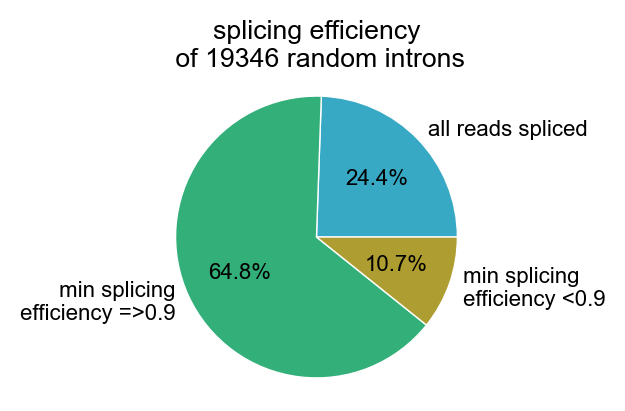

[4730, 12537, 2079]


In [34]:
# CUTOFFS JUST FOR PIE CHART!!!
total_GFP_threshold = 0
unspl_count_threshold = 1
sample_num = 4
unspl_threshold = 0.9

# identify which introns in which samples have above some read count threshold for spliced AND unspliced reads
mask_spliced = total_GFP >= total_GFP_threshold
mask_unspliced = unspliced_GFP_counts >= unspl_count_threshold
combined_mask = mask_spliced & mask_unspliced

# get splicing efficiencies for each intron averaged across only these samples
filtered_ratios = np.where(combined_mask, ratio_spliced_to_total, np.nan)
spl_eff_median = np.nanmedian(filtered_ratios, axis=1)
spl_eff_min = np.nanmin(filtered_ratios, axis=1)
median_unspliced_mask = spl_eff_median<unspl_threshold
min_unspliced_mask = spl_eff_min<unspl_threshold

labels = ['all reads spliced',
          f'min splicing\nefficiency =>{unspl_threshold}',
          f'min splicing\nefficiency <{unspl_threshold}']

sizes = [(unspliced_GFP_counts.sum(1)==0).sum(),
         (spl_eff_min>=unspl_threshold).sum(),
         (spl_eff_min<unspl_threshold).sum()]

colors = [nicecolors(i) for i in [3,2,1]]
explode = (0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=0, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title(f'splicing efficiency\n of {np.sum(sizes)} random introns')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(sizes)

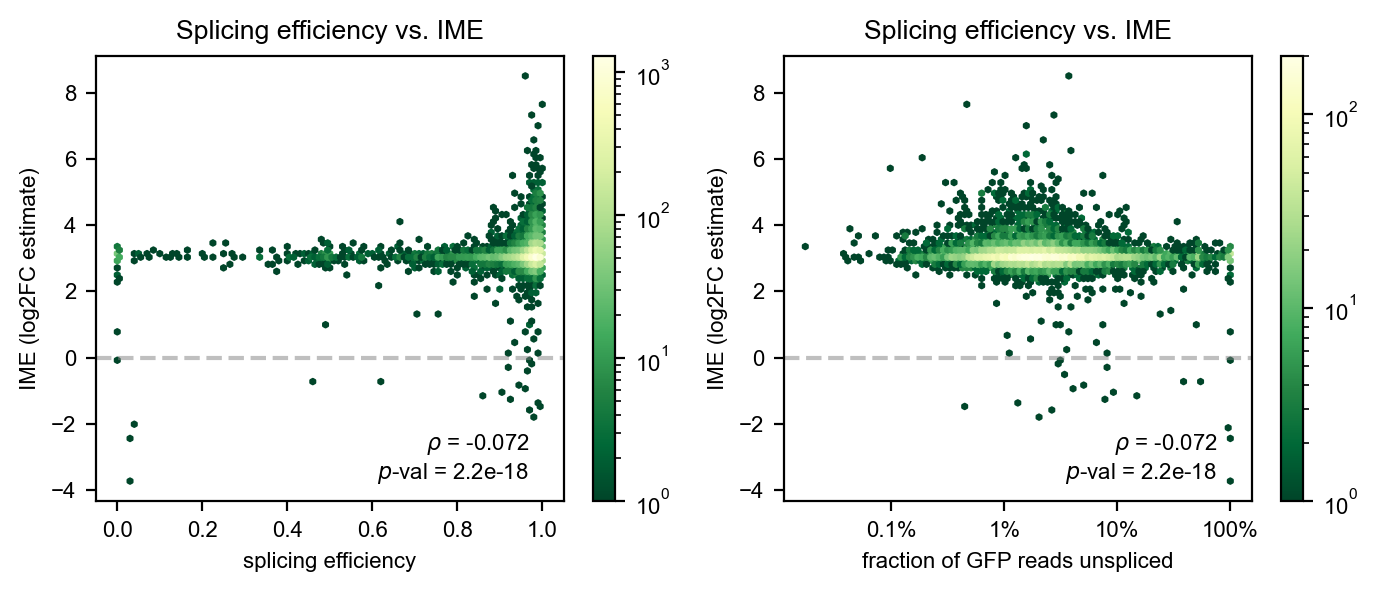

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

hb1=ax1.hexbin(spl_eff_median,
           norm_l2fc, cmap='YlGn_r',
           bins='log')
ax1.set_title(f'Splicing efficiency vs. IME')
ax1.set_xlabel('splicing efficiency')
ax1.set_ylabel('IME (log2FC estimate)')
cb1 = fig.colorbar(hb1)

x,y = 1-spl_eff_median,norm_l2fc
nanmask = np.isnan(x)|np.isnan(y)
coef, _ = stats.spearmanr(x[~nanmask],y[~nanmask])
ax1.annotate(f'        $\\rho$ = {coef:.3f}\n$p$-val = {_:.1e}', xy=(0.6,0.05), xycoords="axes fraction", fontsize=8)
ax1.axhline(0, c='grey', alpha=0.5, linestyle='--')

hb2=ax2.hexbin(np.log10(1-spl_eff_median),
           norm_l2fc, cmap='YlGn_r',
           bins='log')
ax2.set_title(f'Splicing efficiency vs. IME')
ax2.set_xlabel('fraction of GFP reads unspliced')
ax2.set_ylabel('IME (log2FC estimate)')
ax2.set_xticks([-3,-2,-1,0],["0.1%","1%","10%","100%"])

x,y = np.log10(1-spl_eff_median),norm_l2fc
nanmask = np.isnan(x)|np.isnan(y)
coef, _ = stats.spearmanr(x[~nanmask],y[~nanmask])
ax2.annotate(f'        $\\rho$ = {coef:.3f}\n$p$-val = {_:.1e}', xy=(0.6,0.05), xycoords="axes fraction", fontsize=8)
ax2.axhline(0, c='grey', alpha=0.5, linestyle='--')

cb2 = fig.colorbar(hb2)

plt.tight_layout()
plt.show()

In [36]:
stats.spearmanr(x[~nanmask],y[~nanmask])

SignificanceResult(statistic=-0.07227369189642241, pvalue=2.1651087158919757e-18)

In [37]:
# CUTOFFS FOR EVERYBODY ELSE
total_GFP_threshold = 10
unspl_count_threshold = 2
sample_num = 4
unspl_threshold = 0.9

In [38]:
# identify which introns in which samples have above some read count threshold for spliced AND unspliced reads
mask_spliced = total_GFP >= total_GFP_threshold
mask_unspliced = unspliced_GFP_counts >= unspl_count_threshold
combined_mask = mask_spliced & mask_unspliced
#combined_mask = total_GFP >= 100

# get splicing efficiencies for each intron averaged across only these samples
filtered_ratios = np.where(combined_mask, ratio_spliced_to_total, np.nan)
spl_eff = np.nanmean(filtered_ratios, axis=1)
spl_eff_median = np.nanmedian(filtered_ratios, axis=1)
spl_eff_min = np.nanmin(filtered_ratios, axis=1)

# if the information about splicing is only coming from one sample we probably shouldn't trust it
# let's only give a splicing efficiency value to introns which meet the read cutoff in at least some number of samples
confident_mask = np.sum(~np.isnan(filtered_ratios), axis=1) >= sample_num

# and define a mask to see what fraction of these are spliced below some cutoff
unspliced_mask = spl_eff<unspl_threshold
median_unspliced_mask = spl_eff_median<unspl_threshold
min_unspliced_mask = spl_eff_min<unspl_threshold

# how many introns come out of these filters?
print(f'total introns considered: {len(spl_eff)}')
print(f'introns with at least one sample that has {total_GFP_threshold} total GFP + {unspl_count_threshold} unspliced: {np.sum(~np.isnan(spl_eff))}')
print(f'introns with at least {sample_num} samples that meet this criteria: {len(spl_eff[confident_mask])}')
print(f'how many of those are <{unspl_threshold*100:.0f}% spliced on average? {len(spl_eff[confident_mask&unspliced_mask])}')
print(f'how many of those have MEDIAN spl eff <{unspl_threshold*100:.0f}%? {len(spl_eff[confident_mask&median_unspliced_mask])}')
print(f'how many of those have MIN spl eff <{unspl_threshold*100:.0f}%? {len(spl_eff[confident_mask&min_unspliced_mask])}')
print()

total introns considered: 19346
introns with at least one sample that has 10 total GFP + 2 unspliced: 13951
introns with at least 4 samples that meet this criteria: 1650
how many of those are <90% spliced on average? 101
how many of those have MEDIAN spl eff <90%? 55
how many of those have MIN spl eff <90%? 338



/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82857/2859490197.py:9: RuntimeWarning: Mean of empty slice
  spl_eff = np.nanmean(filtered_ratios, axis=1)
/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82857/2859490197.py:10: RuntimeWarning: All-NaN slice encountered
  spl_eff_median = np.nanmedian(filtered_ratios, axis=1)
/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82857/2859490197.py:11: RuntimeWarning: All-NaN slice encountered
  spl_eff_min = np.nanmin(filtered_ratios, axis=1)


In [39]:
# sort array by median splicing efficiency
arr = filtered_ratios[confident_mask]
sorted_arr = arr[np.argsort(1-np.nanmedian(arr, axis=1))]

# convert to DataFrame for plotting
df = pd.DataFrame(sorted_arr, columns=range(sorted_arr.shape[1]))
df['Intron'] = range(arr.shape[0])
df_long = df.melt(id_vars='Intron', var_name='Sample', value_name='spl_eff')
median_values = df_long.groupby(['Intron'])['spl_eff'].median().reset_index()
df_long = df_long.merge(median_values, on=['Intron'], suffixes=('', '_median'))
unspliced_df = df_long[df_long.spl_eff_median<=unspl_threshold]

# scale colorbar to data
SF_cmap = sns.color_palette("icefire", as_cmap=True)
full_cmap = sns.color_palette(SF_cmap(median_values.spl_eff[::-1]))
unspl_cmap = sns.color_palette(SF_cmap(median_values.spl_eff[median_values.spl_eff<=unspl_threshold][::-1]))

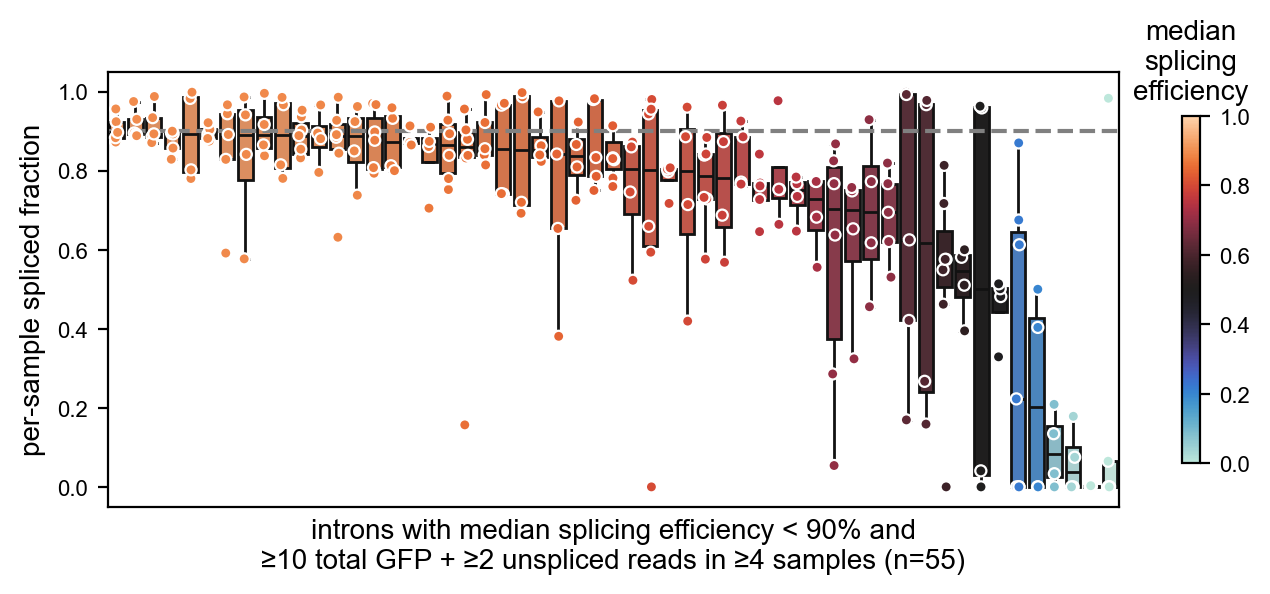

In [42]:
# plot the worst splicers
fig = plt.figure(figsize=(7,3))

bp = sns.boxplot(data=unspliced_df, x='Intron', y='spl_eff', hue='spl_eff_median', 
                 palette=unspl_cmap, showfliers=False, legend=False)
sns.stripplot(x='Intron', y='spl_eff', data=unspliced_df, hue='spl_eff_median',
              s=4, edgecolor = 'w', linewidth = 0.8,
              palette=unspl_cmap, legend=False)

plt.xticks([])
plt.ylabel(f'per-sample spliced fraction', fontsize=10)
plt.xlabel(f'introns with median splicing efficiency < {unspl_threshold*100:.0f}% and\n≥{total_GFP_threshold} total GFP + ≥{unspl_count_threshold} unspliced reads in ≥{sample_num} samples (n={len(vcs(unspliced_df.Intron))})', fontsize=10)
#≥{unspl_count_threshold} unspliced GFP reads in ≥{sample_num} samples\nand 
#≥{total_GFP_threshold} spliced &

plt.axhline(unspl_threshold, c='grey', linestyle='--')

sm =  ScalarMappable(norm=plt.Normalize(0,1), cmap=plt.get_cmap(SF_cmap, 20))
sm.set_array([])
cbar = fig.colorbar(sm, ax=plt.gca(), shrink=0.8)
cbar.ax.set_title("median\nsplicing\nefficiency", fontsize=10)
cbar.set_ticks(np.arange(0.0,1.1,0.2))
plt.tight_layout()

plt.show()

In [14]:
poorly_spliced_bcs = list(np.array(bcs)[confident_mask&median_unspliced_mask])

In [15]:
'TATACCTCAACCAATATT' in poorly_spliced_bcs

False

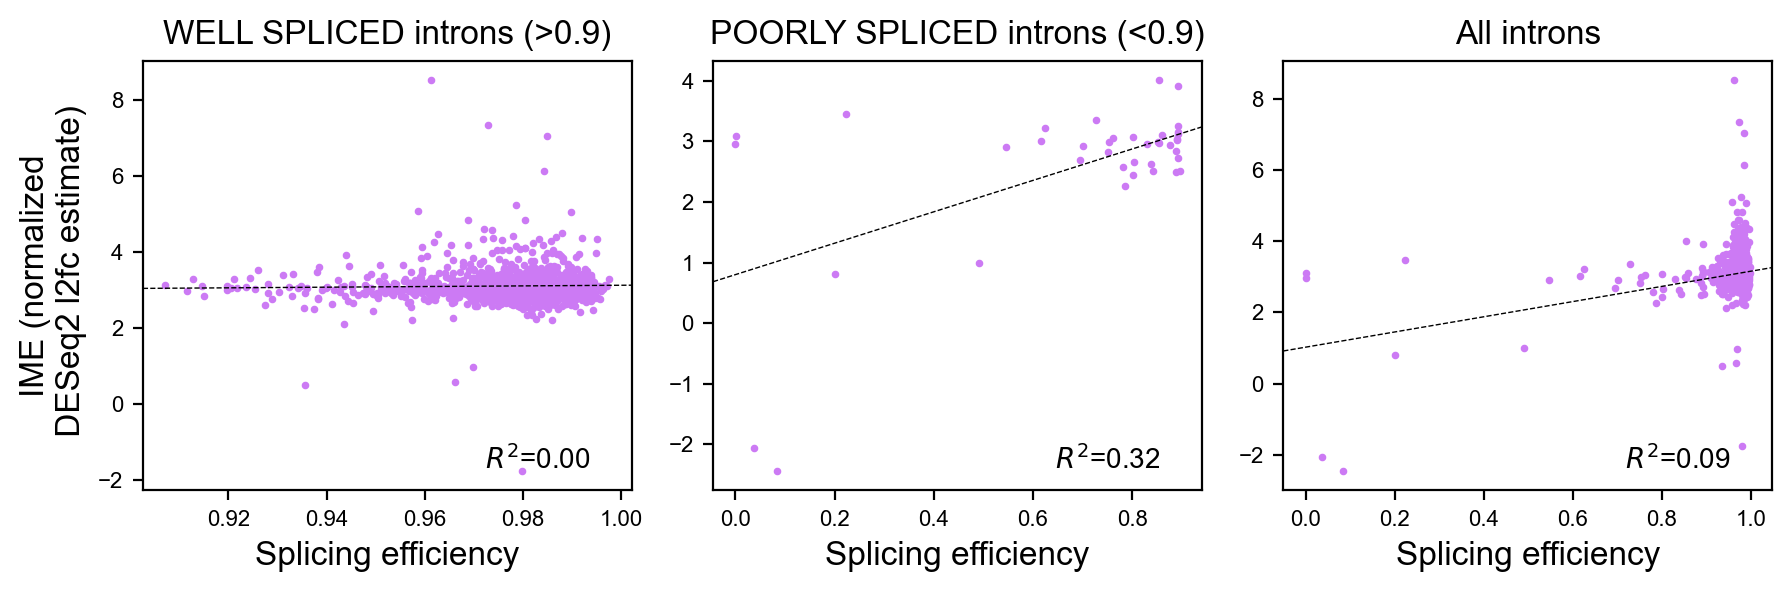

In [16]:
# what is the relationship between splicing and IME???

spl_eff_conf = spl_eff_median[confident_mask]
IME_conf = (norm_l2fc[confident_mask])
cryptic_mask = [bc not in cryptic_spliced_bcs for bc in np.array(bcs)[confident_mask]]

fig, axes = plt.subplots(1,3, figsize=(9,3))

for i, mask in [(0,spl_eff_conf>unspl_threshold),
                (1,spl_eff_conf<unspl_threshold),
                (2,spl_eff_conf>-1)]:
    
    xdata, ydata = spl_eff_conf[mask&cryptic_mask], IME_conf[mask&cryptic_mask]
    #xdata2, ydata2 = spl_eff_conf[mask&cryptic_mask], IME_conf[mask&cryptic_mask]

    axes[i].scatter(xdata,ydata, s=3, color=nicecolors(4))
    #axes[i].scatter(xdata2,ydata2, s=5, color='gold')
    axes[i].set_xlabel('Splicing efficiency', fontsize=12)
    if i==0:
        axes[i].set_ylabel('IME (normalized\n DESeq2 l2fc estimate)', fontsize=12)
    axes[i].set_xlim(axes[i].get_xlim())
    axes[i].set_ylim(axes[i].get_ylim())
    #axes[i].set_ylim(-6,4)
    axes[i].set_title([f'WELL SPLICED introns (>{unspl_threshold})',
                       f'POORLY SPLICED introns (<{unspl_threshold})',
                       'All introns'][i], fontsize=12)
    
    coef, _ = stats.pearsonr(xdata,ydata)
    axes[i].annotate(f'$R^2$={coef**2:.2f}', xy=(0.7,0.05), xycoords="axes fraction", fontsize=10)
    
    result = stats.linregress(xdata, ydata)
    b, m = result.intercept, result.slope
    axes[i].axline(xy1=(0, b), slope=m, 
               linewidth=0.5, linestyle='--', color='black',
               label=f'$y = {m:.1f}x {b:+.1f}$')
     
    #axes[i].legend(fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
(spl_eff_conf<unspl_threshold).sum()

55